In [1]:
## Spark session libraries
import findspark
findspark.init()
import pyspark
findspark.find()

from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

## Required for parsing the file as csv
import csv
from io import StringIO
from itertools import islice, repeat

## For preprocessing
from re import search, split, sub, compile as comp
import numpy as np

## For Plots
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm, colors


import warnings

In [2]:
sc = SparkContext(appName="SDDM", master='local[*]')
ss = SparkSession.builder.appName('SDDM_2').getOrCreate()
print(sc.pythonVer)
print (sc.master)
sc

3.7
local[*]


<SparkContext master=local[*] appName=SDDM>

In [3]:
def parseCSV(csvRow) :
    '''Parses a row into a list of elements '''
    data = StringIO(csvRow)
    dataReader = csv.reader(data, lineterminator = '')
    return(next(dataReader))

def readFileAsCSV(session, filepath):
    '''Reads a files as text file and then parses each row and returns a list of list: 
        [[Row]
         [Row]
         [Row]]
     '''
    try:
        data = session.textFile(name = str(filepath))
        data = data.map(parseCSV)
    except:
        print('Failed to read the file!')
        data = []
    return data

In [4]:
def tickTime(x, ind):
    '''Extracts the month and year from the issue date'''
    try:
        m = int(x[ind][0:2])
        y = int(x[ind][6:10])
    except:
        m = '0'
        y = '0'    
    x.append(str(m))
    x.append(str(y))
    return x

def street_preprocess(x, ind):
    '''Preprocess the street names'''
    s = x[ind]
    s = s.replace('AVENUE','AVE').replace('STREET','ST').replace('BLVD','BL')
    s = s.replace('\sEAST\s',' E ').replace('\sWEST\s',' W ').replace('\sNORTH\s',' N ').replace('\sSOUTH\s',' S ')
    s = s.replace('\sROAD\s',' RD ').replace('\sEXPY\s','EXWY').replace('\sPARKWY\s','PKWY').replace('\sISLAND\s','ISL')
    s = s.replace('\sFIRST\s','1').replace('\sSECOND\s','2').replace('\sTHRID\s','3')
    s = s.replace('\sFOURTH\s','4').replace('\sFIVETH\s','5').replace('\sSIXTH\s','6')
    s = s.replace('\sSEVENTH\s','7').replace('\sEIGHTH\s','8').replace('\sNINETH\s','9').replace('\sTENTH\s','10')
    s = s.split()
    result = [x if not search(r'\d', x) else sub('[^0-9]','', x) for x in s]
    result = ' '.join(result)
    x[ind] = result.lower()
    return x

def rState(x, ind):
    if x[ind] == 'NY':
        x.append('NY')
    else:
        x.append('Other')
    return x

def violationType(x, ind):
    mydict = {"Misc":[35,41,90,91,94],
                        "No Parking":[20,21,23,24,27],
                        "No Standing":[3,4,5,6,8,10,11,12,13,14,15,16,17,18,19,22,25,26,30,31,40,44,54,57,58,63,64,77,78,81,89,92],
                        "Permit/Doc Issue":[1,2,29,70,71,72,73,76,80,83,87,88,93,97],
                        "Plate Issues":[74,75,82],
                        "Obstructing Path":[7,9,36,45,46,47,48,49,50,51,52,53,55,56,59,60,61,62,66,67,68,79,84,96,98],
                        "Overtime":[28,32,33,34,37,38,39,42,43,65,69,85,86]
                        }
    label = ''
    try:
        for key, value in mydict.items():
             for y in value:
                    if y == int(x[ind]):
                        label = key
    except: 
        label = ''
        
    x[ind] = label
    return x
    
def sH(x, ind):
    ''' Extracts the street number and house number from House number column
        Some house numbers are: 123-34, 45-56 and some are 34, 45 etc
    '''
    house_num = x[ind]
    try:
        if house_num == '':
            s = '0'
            h = '0'
        else:
            cond = '-' in house_num
            if cond:
                s, h = house_num.split('-')
            else:
                s = int(house_num)
                h = '0'
    except:
        s = '0'
        h = '0'
    x.append(str(s))
    x.append(str(h))
    return x
    
def preprocessedCSV(session, filepath):
    '''
    Reads the csv files, and then converts Issue date to date and month
    '''
    data = readFileAsCSV(session, filepath)
    header = data.take(1)[0]
    ## Extracting the month and year
    data = data.map(lambda x: tickTime(x, header.index('Issue Date')))
    header.append('Issue Month')
    header.append('Issue Year')
    
    ## Removing the header line
    data = data.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)
    ## Preprocessing the street names
    data = data.map(lambda x: street_preprocess(x, header.index('Street Name')))    
    ## Extracts the street and house number
    data = data.map(lambda x: sH(x, header.index('House Number')))
    header.append('Street')
    header.append('House')
    data = data.map(lambda x: rState(x, header.index('Registration State')))
    header.append('RState')
    data = data.map(lambda x: violationType(x, header.index('Violation Code')))
    return data, header

### Coordinate file processing

In [5]:
def streetHouse(x):
    '''
        Extracts the street and house number ranges for a street name and coordinate
    '''
    house_num = x[0]
    try:
        if house_num == '':
            s_min = '0'
            s_max = '0'
            h_min = '0'
            h_max = '0'
        else:
            cond = '-' in house_num
            if cond:
                l_s_min, l_h_min = x[0].split('-')
                l_s_max, l_h_max = x[1].split('-')
                r_s_min, r_h_min = x[4].split('-')
                r_s_max, r_h_max = x[5].split('-')

                l_s_min, l_h_min, l_s_max, l_h_max = int(l_s_min), int(l_h_min), int(l_s_max), int(l_h_max)
                r_s_min, r_h_min, r_s_max, r_h_max = int(r_s_min), int(r_h_min), int(r_s_max), int(r_h_max)
                s_min = min(l_s_min, r_s_min)
                s_max = max(l_s_max, r_s_max)

                h_min = min(l_h_min, r_h_min)
                h_max = max(l_h_max, r_h_max)

            else:
                left_min = int(x[0])
                left_max = int(x[1])
                right_min = int(x[4])
                right_max = int(x[5])

                s_min = min(left_min, right_min)
                s_max = max(left_max, right_max)

                h_min = '0'
                h_max = '0'
    except:
        s_min = '0'
        s_max = '0'
        h_min = '0'
        h_max = '0'
        
    x.append(str(s_min))
    x.append(str(s_max))
    x.append(str(h_min))
    x.append(str(h_max))
    return x

def createCoordsFiles(session, filepath):
    coords = readFileAsCSV(session, filepath) 
    ## Getting the header
    coords_header = coords.take(1)[0]
    ## Preprocessing the street names
    coords = coords.map(lambda x: street_preprocess(x, coords_header.index('full_stree')))    
    ## Removing the first line
    coords = coords.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)
    ## Finding the street numbers and house number limits
    coords = coords.map(streetHouse)
    ## Extracting the required columns
    coords = coords.map(lambda x: [x[28],x[32],x[33],x[34],x[35], x[3]])
    coords_header = ['full_stree', 'S_min', 'S_max', 'H_min', 'H_max', 'the_geom']
    
    return coords, coords_header

In [6]:
def matchstreet(t, c):
    '''
    Based on the street and house number in tickets dataframe finds the coordintae value in centerline dataframe
    and merges the coordinate value to it.
    '''
    ## Making the columns integers for comparision
    t =  t.withColumn("Issue_Month", t["Issue_Month"].cast('integer'))
    t =  t.withColumn("Issue_Year", t["Issue_Year"].cast('integer'))
    t =  t.withColumn("Street", t["Street"].cast('integer'))
    t =  t.withColumn("House", t["House"].cast('integer'))
    c = c.select('full_stree',  c.S_min.cast('integer'),c.S_max.cast('integer'),\
                          c.H_min.cast('integer'),c.H_max.cast('integer'),'the_geom')
    ## performs inner join on the tickets. 
    merged = t.join(c, [t.Street_Name == c.full_stree,t.Street>=c.S_min, t.Street<=c.S_max,t.House >=c.H_min, t.House<= c.H_min],'inner')
    return merged.dropDuplicates(subset=['Summons_Number'])

In [7]:
def getData(sc, filepath, filename, year):
    '''Reads each file in a loop and returns a list of RDDs'''
    tickets = []
    for yr in year:
        filelocation = str(filepath)+str(filename)+str(yr)+".csv"
        print(filelocation)
        parking_data, header = preprocessedCSV(sc, filelocation)
        tickets.append(parking_data)
    return tickets, header

In [8]:
def group_data(data, Val, Key):
    pairs = data.map(lambda x: (x[Key], x[Val]))
    return pairs.groupByKey().collect()

def group_data_toList(y, groupby):
    '''
    Input:
        - y: Grouped pyspark data returned from group_data function
        - groupby: Column name to remove an extra element
    '''
    lab = list(map(lambda x:x[0], y))
    val = list(map(lambda x:len(x[1]), y))
    try:
        kick = lab.index(groupby)
        lab.pop(kick)
        val.pop(kick)
    except:
        0
    if groupby=='Issue Month' or groupby == 'Violation Code':
        lab = list(map(lambda x: int(x), lab))
    return [lab,val]

In [9]:
def plot(ax, header, data, year, groupby, pt, plot_data):
    '''
    Input:
        - data: PySpark parsed CSV
        - groupby: Column name for grouping the data 
        - pt: Plot type
        - plot data: Variables required for bar plot
        
    Output: 
        - Plot
    '''
    if pt=='bar':
        col, val, axis_labels, legend_labels = plot_data
        
        data = data[data.Issue_Year == year]
        
        cat_index = data.columns.get_loc(col)
        cat1 = data[data[cat_index] == val]
        cat2 = data[data[cat_index] != val]
        cat2 = cat2.groupby('Issue_Month').sum() 
        print(cat2)
        ## plotting the graph
        ax.bar(cat1.Issue_Month, cat1[:, 4], width = 0.5, label=legend_labels[0]) 
        ax.bar(cat2.Issue_Month, cat2[:, 4], width = 0.5, label=legend_labels[1])
        
        ax.legend()
        ax.set_xlabel(groupby, fontsize=18)
        ax.set_ylabel('Number of tickets', fontsize=18)
        ax.set_title('Parking tickets for the year '+str(year-1), fontsize=22)
    
    if pt == 'pie':
        #try:
            #groupby_index = header.index(groupby)
            #count_column = header.index('Summons Number')
            
            label, data = group_data_toList(group_data(data , Val=count_column, Key=groupby_index), groupby)
            title = 'Parking ticket '+str(groupby)+' for the year '+str(year-1)
            
            if groupby == 'Violation Code': 
                ## Defining the violation code merges as a dictionary
                labs = {"Misc":[35,41,90,91,94],
                        "No Parking":[20,21,23,24,27],
                        "No Standing":[3,4,5,6,8,10,11,12,13,14,15,16,17,18,19,22,25,26,30,31,40,44,54,57,58,63,64,77,78,81,89,92],
                        "Permit/Doc Issue":[1,2,29,70,71,72,73,76,80,83,87,88,93,97],
                        "Plate Issues":[74,75,82],
                        "Obstructing Path":[7,9,36,45,46,47,48,49,50,51,52,53,55,56,59,60,61,62,66,67,68,79,84,96,98],
                        "Overtime":[28,32,33,34,37,38,39,42,43,65,69,85,86]
                        }
                ## Count based on the grouping
            
                temp = defaultdict(list)
                for i in range(len(label)):
                    for key, val in labs.items():
                        if label[i] in val:
                            if temp[key] == []:
                                temp[key] = 0
                            else:
                                temp[key] = temp[key]+data[i]

                ## Ordering data based on the dictionary 
                label, data  = list(), list()
                for key in labs.keys():
                    label.append(key)
                    data.append(temp[key])    

            ## Defining color for each category
            temp = defaultdict(list)
            for l,c in zip(labs,cm.tab20(range(len(labs)))):
                temp[l]=c

            centre_circle = plt.Circle((0,0),0.85,fc='white') ## radius to make it like a donut
            explode = np.full(len(label), 0.04) ## Gaps between the categories

            pat = ax.pie(list(map(lambda x: x*100/sum(data), data)), labels=label, textprops={'fontsize': 20}, autopct='%1.1f%%', startangle=90, pctdistance=0.6, explode = explode)
            if groupby == 'Violation Code':
                for pie_wedge in pat[0]:
                    pie_wedge.set_edgecolor('white')
                    pie_wedge.set_facecolor(temp[pie_wedge.get_label()]) # Assigning color code for each catergory

            ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
            ax.set_title(title, fontsize =22, pad=20)
            plt.gcf().gca().add_artist(centre_circle)
        #except:
        #    print('Failed to plot!')        
    return ax 


def EDA(header, tickets, year, groupby, pt, plotdim, plot_data):
    fig = plt.figure(figsize=(30, 25))
    axs=plt.GridSpec(plotdim[0], plotdim[1], hspace=0.15, wspace=0.1)
    tickets = tickets.select('Issue_Year', 'Issue_Month', str(plot_data[0])).groupBy('Issue_Year', 'Issue_Month', plot_data[0]).count().toPandas()
    for i in range(len(year)):
        tickets.filter(lambda x: x)
        plot(fig.add_subplot(axs[i]), header, tickets, year[i], groupby, pt, plot_data)
    plt.savefig('EDA_'+str(groupby)+'_'+str(pt)+'.png',  bbox_inches='tight')

In [10]:
%%time 
filepath = 'SDDM Data/'
filename = 'Parking_Violations_Issued_-_Fiscal_Year_'
year = list(range(2015, 2021))
tickets, header = getData(sc, filepath, filename, year)
all_tickets = tickets[0]
for i in range(1, len(year)):
    all_tickets = all_tickets.union(tickets[i])

SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2016.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2017.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2018.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2019.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2020.csv
Wall time: 5.65 s


In [11]:
%%time
heads = [x.replace(' ', '_') for x in header]
all_tickets_df = ss.createDataFrame(all_tickets, schema=heads)
coords, c_header = createCoordsFiles(sc, 'SDDM Data/Centerline.csv')
coord_df = ss.createDataFrame(coords, schema=c_header)
all_tickets_coordinates = matchstreet(all_tickets_df, coord_df)
all_tickets_coordinates = all_tickets_coordinates.filter(F.col('Issue_Year').isin(year))

Wall time: 13.6 s


#### This is how coordinate file look like

In [110]:
coord_df.show(5)

+--------------------+-----+-----+-----+-----+--------------------+
|          full_stree|S_min|S_max|H_min|H_max|            the_geom|
+--------------------+-----+-----+-----+-----+--------------------+
|mitsubishi wild w...|    0|    0|    0|    0|MULTILINESTRING (...|
|              28 ave|  215|  215|    0|   27|MULTILINESTRING (...|
|     schermerhorn st|  316|  399|    0|    0|MULTILINESTRING (...|
|       arlington ave| 5602| 5699|    0|    0|MULTILINESTRING (...|
|           queens bl|    0|    0|    0|    0|MULTILINESTRING (...|
+--------------------+-----+-----+-----+-----+--------------------+
only showing top 5 rows



#### This is how each ticket file look like

In [94]:
tick_df.show(5)

+--------------+--------------+------------+---------------+-----------+----------+------+-----+
|Summons_Number|Violation_Code|House_Number|    Street_Name|Issue_Month|Issue_Year|Street|House|
+--------------+--------------+------------+---------------+-----------+----------+------+-----+
|    1447152396|            21|          21|   old broadway|          6|      2019|    21|    0|
|    1447152402|            20|         545|       w 126 st|          6|      2019|   545|    0|
|    1447152554|            19|         509|       w 125 st|          6|      2019|   509|    0|
|    1447152580|            19|         501|       w 125 st|          6|      2019|   501|    0|
|    1447152724|            48|         341|st nicholas ave|          7|      2019|   341|    0|
+--------------+--------------+------------+---------------+-----------+----------+------+-----+
only showing top 5 rows



In [174]:
all_tickets.count()

65967263

In [14]:
all_tickets_coordinates.count()

34619770

In [28]:
cound_pd

,Issue_Month,Issue_Year,count
0,6,2016,342107
1,7,2018,564639
2,1,2016,417799
3,1,2017,457887
4,3,2017,516492
...,...,...,...
67,5,2015,531453
68,12,2018,501939
69,5,2017,543678
70,10,2017,597887


In [64]:
test = cound_pd[cound_pd.Issue_Year == 2015]
test

,Issue_Month,Issue_Year,count
17,3,2015,533728
21,11,2015,483735
22,1,2015,434993
24,10,2015,546658
27,12,2015,370893
28,6,2015,550874
38,9,2015,490965
46,7,2015,495572
54,2,2015,411589
64,8,2015,525506


In [ ]:
%%time
pandasBoi = all_tickets_df.select('Issue_Year', 'Issue_Month', 'RState').filter(F.col('Issue_Year').isin(2015)).filter(F.col('RState').isin('NY')).groupBy('Issue_Month').count().toPandas()

In [19]:
all_tickets_df.select('RState').take(5)

[Row(RState='Other'),
 Row(RState='NY'),
 Row(RState='NY'),
 Row(RState='NY'),
 Row(RState='NY')]

In [15]:
## Bar plot
category='RState'
value='NY' 
axis_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']  
legend_labels= ['New York', 'Other Cities']
plot_data = [category, value, axis_labels, legend_labels]

In [1]:
%%time
groupby = 'Issue Month'
EDA(header, all_tickets_coordinates, year, groupby, 'bar', [int(len(year)/2),2], plot_data)

Wall time: 0 ns


CPU times: user 13.4 s, sys: 3.13 s, total: 16.5 s
Wall time: 22min 42s


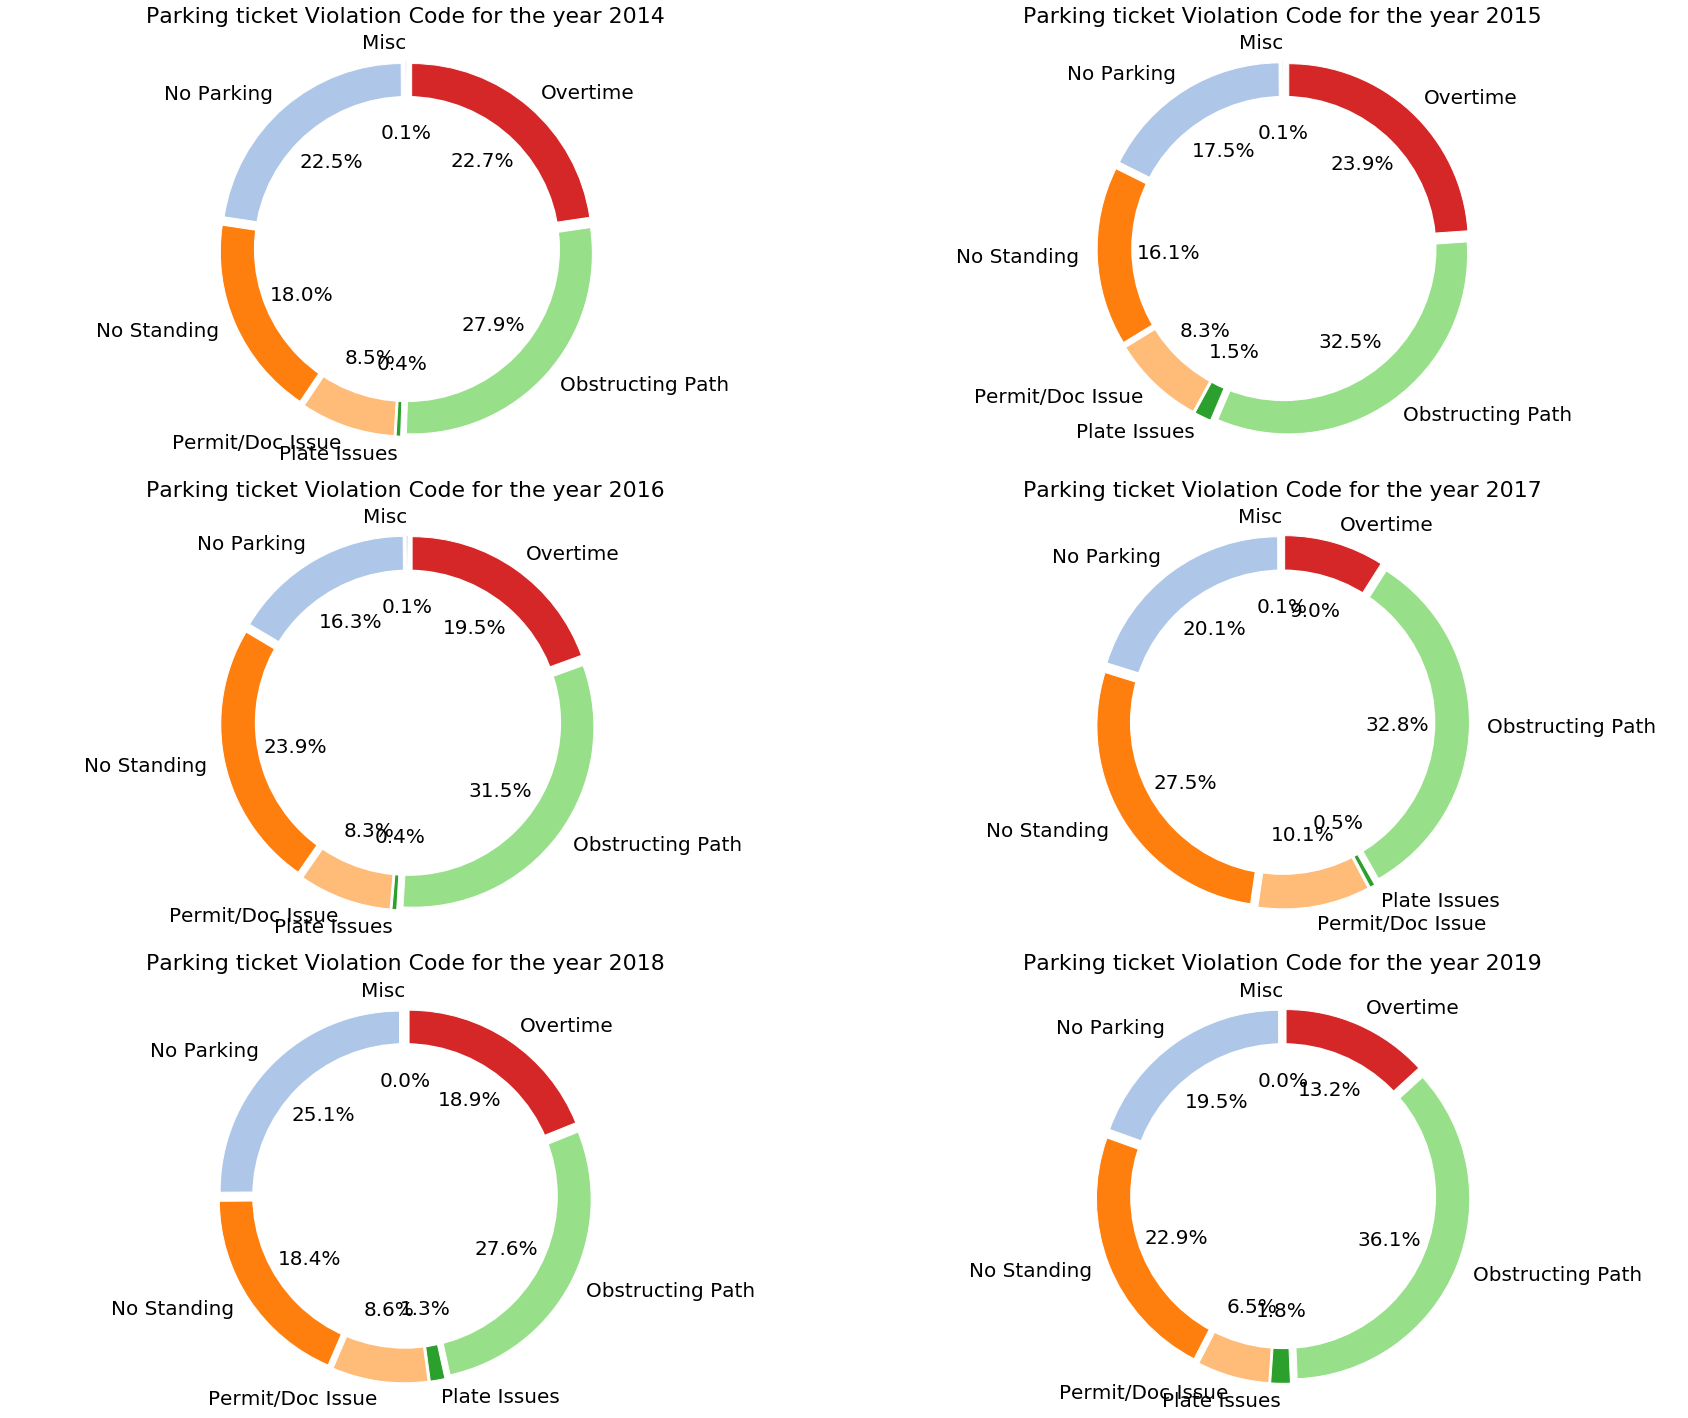

In [19]:
%%time

## Pie chart

groupby = 'Violation Code'
plot_data = []
EDA(header, tickets, year, groupby, 'pie', [int(len(year)/2),2], plot_data)

In [19]:
sc.stop()
ss.stop()